
# Housing Prices: Linear and Logistic Regression

Run the cells in order. The notebook covers:
1. Data loading and preprocessing  
2. **Task 1:** Linear Regression for price prediction  
3. **Task 2:** Logistic Regression for classifying above-median homes  
4. **Task 3:** Comparison and short reflection  


In [2]:

# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ML tools
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, roc_curve, auc

# Inline plots
%matplotlib inline



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\emina\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\emina\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\emina\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_lo

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\emina\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\emina\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\emina\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_lo

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.




## Load dataset
Place `houses.csv` in the same folder as this notebook or adjust the path.


In [3]:

# Load CSV
df = pd.read_csv("houses.csv")
df.head()


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA



## Select target, split, and build preprocessing
The code picks a common price column automatically. If none is found, it falls back to the last numeric column.


In [4]:

# Target selection
candidate_targets = ["price", "SalePrice", "median_house_value", "HousePrice", "target"]
target_col = None
for c in df.columns:
    if c.lower() in [t.lower() for t in candidate_targets]:
        target_col = c
        break

if target_col is None:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not numeric_cols:
        raise ValueError("No numeric columns found. Cannot define a target variable.")
    target_col = numeric_cols[-1]

y = df[target_col]
X = df.drop(columns=[target_col])

# Train-test split (same split used for both tasks for fairness)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Column selectors
numeric_features = selector(dtype_include=np.number)(X_train)
categorical_features = selector(dtype_exclude=np.number)(X_train)

# Pipelines
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

print("Target column:", target_col)
print("Numeric features:", len(numeric_features))
print("Categorical features:", len(categorical_features))


Target column: price
Numeric features: 12
Categorical features: 5



## Quick EDA: top-3 numeric features vs price


Top 3 correlated numeric features: ['sqft_living', 'sqft_above', 'bathrooms']


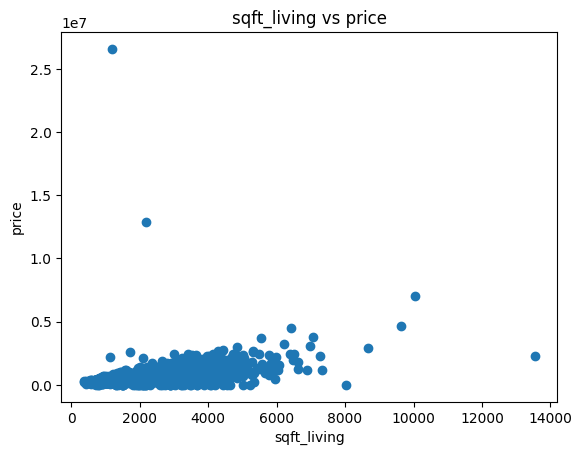

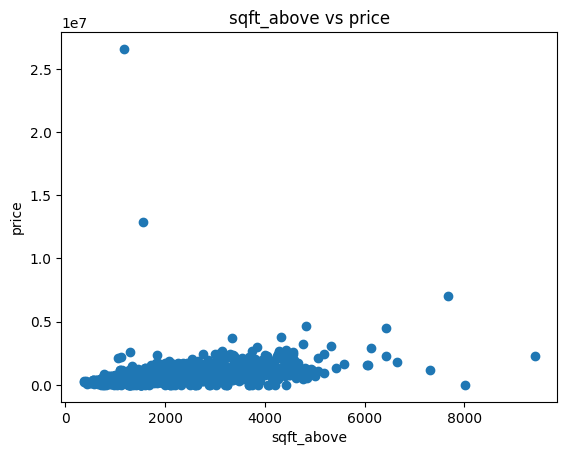

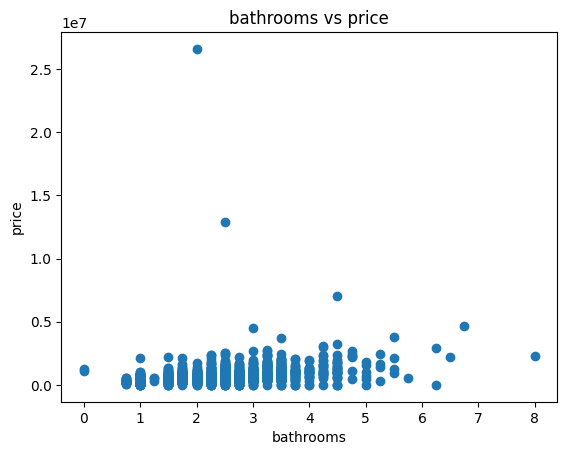

In [5]:

top3_feats = []
if len(numeric_features) > 0:
    corr = df[numeric_features + [target_col]].corr()[target_col].drop(labels=[target_col])
    corr_abs = corr.abs().sort_values(ascending=False)
    top3_feats = corr_abs.head(min(3, len(corr_abs))).index.tolist()
    print("Top 3 correlated numeric features:", top3_feats)

    for feat in top3_feats:
        plt.figure()
        plt.scatter(df[feat], df[target_col])
        plt.xlabel(feat)
        plt.ylabel(target_col)
        plt.title(f"{feat} vs {target_col}")
        plt.show()
else:
    print("No numeric features available for correlation plot.")



## Task 1: Linear Regression — Predict house prices


Test MSE (Linear Regression): 1151775009608.9331


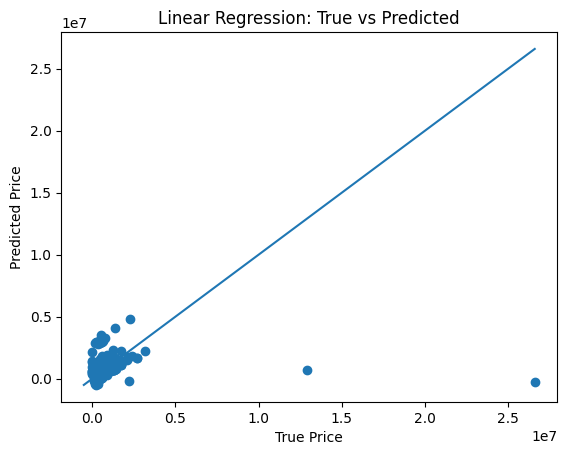

In [6]:

linreg_model = Pipeline(steps=[("preprocess", preprocess), ("model", LinearRegression())])
linreg_model.fit(X_train, y_train)
y_pred_reg = linreg_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_reg)

print(f"Test MSE (Linear Regression): {mse:.4f}")

plt.figure()
plt.scatter(y_test, y_pred_reg)
min_val = min(np.min(y_test), np.min(y_pred_reg))
max_val = max(np.max(y_test), np.max(y_pred_reg))
plt.plot([min_val, max_val], [min_val, max_val])
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.title("Linear Regression: True vs Predicted")
plt.show()



## Task 2: Logistic Regression — Classify above-median homes
Label = 1 if price > median price, else 0.


Test Accuracy (Logistic Regression): 0.8761


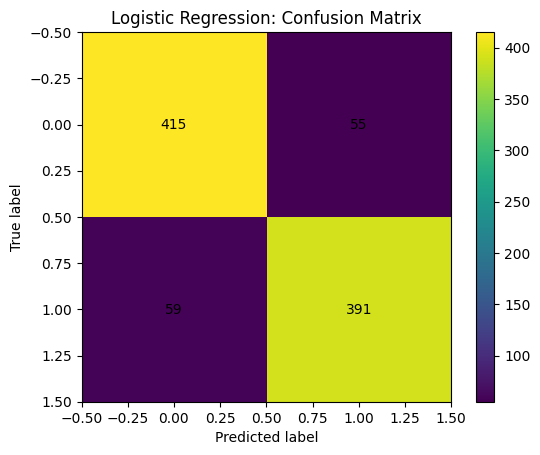

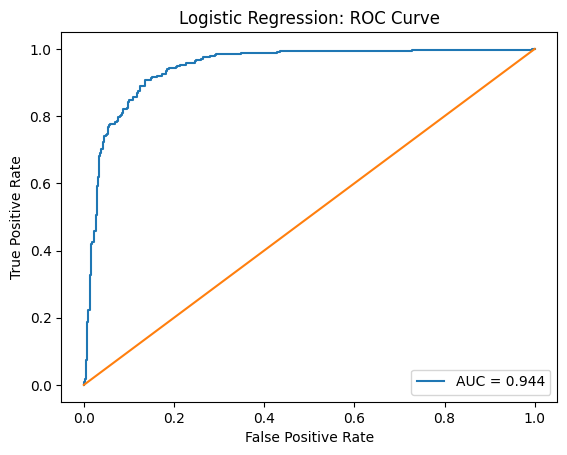

Binary threshold based on median price: 460943.462


In [7]:

median_price = y.median()
y_binary = (y > median_price).astype(int)

# New split to avoid leakage due to different target
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X, y_binary, test_size=0.2, random_state=42)

logreg_model = Pipeline(steps=[("preprocess", preprocess), ("model", LogisticRegression(max_iter=1000))])
logreg_model.fit(X_train_b, y_train_b)

# Predictions and metrics
y_pred_cls = logreg_model.predict(X_test_b)
acc = accuracy_score(y_test_b, y_pred_cls)
print(f"Test Accuracy (Logistic Regression): {acc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test_b, y_pred_cls)
plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Logistic Regression: Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.colorbar()
plt.show()

# ROC curve
y_scores = logreg_model.predict_proba(X_test_b)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_b, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression: ROC Curve")
plt.legend()
plt.show()

print(f"Binary threshold based on median price: {median_price:.3f}")



## Task 3: Comparison and Reflection

# Differences in Outputs, Tasks, and Metrics
- Regression Model (Task 1):

    - Task: Predicts the actual price of a house (continuous value).
    - Output: Numeric prediction for each house.
    - Metric: Mean Squared Error (MSE) is used to evaluate how close predictions are to true prices.
    - Visualization: Scatter plot of true vs. predicted prices.

- Classification Model (Task 2):

    - Task: Classifies whether a house is "expensive" (above median price) or not (binary label).
    - Output: 0 or 1 for each house (not expensive/expensive).
    - Metrics: Accuracy, Confusion Matrix, ROC Curve, and AUC.
    - Visualization: Confusion matrix and ROC curve.

# Real-World Use Cases

- Predicting Prices (Regression):

    - Useful for real estate platforms, automated valuation models, and pricing recommendations.
    - Enables sellers and buyers to estimate market value for negotiation.

- Classifying Expensive Houses (Classification):

    - Useful for filtering listings, targeting marketing, or risk assessment (e.g., insurance).
    - Helps identify luxury segments or properties above a certain threshold.

# Feature Experimentation
- Adding/removing features (e.g., number of rooms, location, amenities) can impact both models:
    - Regression: May improve price prediction accuracy if features are relevant.
    - Classification: May change which houses are classified as expensive, affecting accuracy and AUC.
    - Feature selection and engineering are important for both tasks, but the impact may differ depending on whether the target is continuous or binary.